# QAOA for the UD-MIS problem: Using a Sequence Builder

In [1]:
import numpy as np
import igraph

import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

from pulser import Pulse, Sequence, Register, Simulation
from pulser.devices import Chadoq2
from pulser.waveforms import CustomWaveform

from scipy.optimize import minimize

## 1. Register and Graph

We use the Sequence Builder for the QAOA solution of the MIS problem of the tutorials. We restrict the number of atoms to 5, just to show a proof-of-concept.

A link in the graph corresponds to two atoms that are within the Rydberg Blockade Radius of each other. The radius is obtained using `Chadoq2.rydberg_blockade_radius()`. In this notebook, $\Omega$ is fixed to a frequency of 1 rad/µs.

In [2]:
Rb = Chadoq2.rydberg_blockade_radius(1.*2*np.pi)

In [3]:
def make_graph(coords):
    N = len(coords)
    g = igraph.Graph()
    edges = [[m,n] for m,n in combinations(range(N), r=2) 
              if np.linalg.norm(coords[m] - coords[n]) < Rb]    
    g.add_vertices(N)
    g.add_edges(edges)
    return g

Here, we create an atomic register with 5 atoms and the corresponding graph.

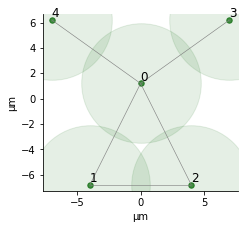

In [4]:
coords = np.array([(0., 0.), (-4, -8), (4, -8), (7, 5), (-7, 5)])
G = make_graph(coords) 
reg = Register.from_coordinates(coords)
reg.draw(blockade_radius=Rb, draw_graph=True, draw_half_radius=True)

This graph has two maximal independent sets: $(1,3,4)$ and $(2,3,4)$, respectively `010111` and `00111` in binary. 

## 2. Build model

In [5]:
layers = 2
guess = {'t': np.random.uniform(8, 10, layers),
         's': np.random.uniform(1, 3, layers)}

In [6]:
guess

{'t': array([8.88242707, 9.48805527]), 's': array([2.14860759, 1.90704676])}

In [7]:
# Parametrized sequence
seq_builder = Sequence(reg, Chadoq2)
seq_builder.declare_channel('ch0','rydberg_global')

t_list = seq_builder.declare_variable('t_list', size=layers)
s_list = seq_builder.declare_variable('s_list', size=layers)

if layers == 1:
    t_list = [t_list]
    s_list = [s_list]
    
for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000*t, 1., 0., 0) 
    pulse_2 = Pulse.ConstantPulse(1000*s, 1., 1., 0)

    seq_builder.add(pulse_1, 'ch0')
    seq_builder.add(pulse_2, 'ch0')

In [8]:
def quantum_loop(parameters):
    t_params, s_params = np.reshape(parameters, (2, layers))
    seq = seq_builder.build(t_list=t_params, s_list=s_params)
    seq.measure('ground-rydberg')
    
    simul = Simulation(seq, sampling_rate=.01)
    results = simul.run()
    return results.sample_final_state()

In [9]:
example_dict = quantum_loop(np.r_[guess['t'], guess['s']])

/Users/seb/Documents/Projects/pasqal/Pulser/pulser/utils.py:38: UserWarning: The given duration is below the machine's precision of 4 ns time steps. It was rounded down to the nearest multiple of 4 ns.
  warnings.warn("The given duration is below the machine's precision"


We can then plot the distribution of the samples, to see the most frequent bitstrings sampled.

In [10]:
def plot_distribution(results):
    C = dict(Counter(results).most_common())
    indexes = ['01011', '00111']  # MIS indexes
    color_dict = {key:'coral' if key in indexes else 'royalblue' for key in C}
    
    plt.figure(figsize=(12,6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color = color_dict.values())
    plt.xticks(rotation='vertical')

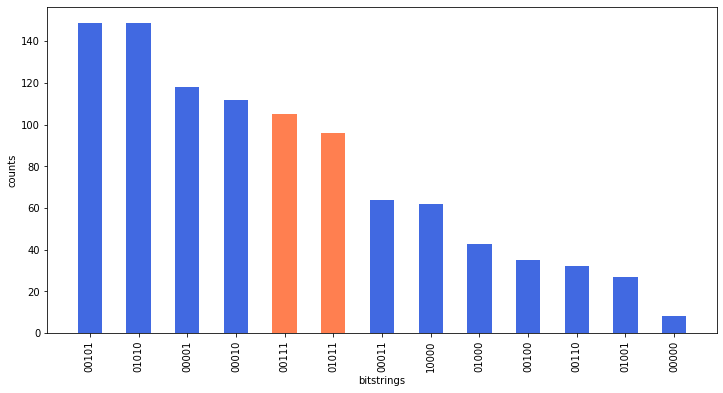

In [11]:
plot_distribution(example_dict);

## 3. Optimization 

We estimate the cost of a sampled state vector by making an average over the samples. Determining the cost of a given bitstring takes polynomial time. The average estimate is then used in the classical loop to optimize the variational parameters $\tau$ and $t$.

In [12]:
def get_cost_colouring(bitstring, G, penalty=10):
    z = np.array(list(bitstring), dtype=int)
    A = np.array(G.get_adjacency().data)
    # Add penalty and bias:
    cost = penalty*(z.T @ np.triu(A) @ z) - np.sum(z)
    return cost 

def get_cost(res,G):
    counter = dict(res)
    cost = sum(counter[key] * get_cost_colouring(key,G) for key in counter) 
    return cost / sum(counter.values()) # Divide by total samples

In [13]:
def func(param,*args):
    G = args[0]
    C = quantum_loop(param)
    cost = get_cost(C,G)
    return cost

We now use a classical optimizer `minimize` in order to find the best variational parameters. This function takes as arguments `func`, the graph `G`and an initial `x0` point for the simplex in Nelder-Mead minimization. The initial point `x0` was estimated beforehand using the best of many initial points, greatly facilitating the optimization process. 

In [14]:
res = minimize(func, 
               args=G,
               x0=np.r_[guess['t'], guess['s']],
               method='Nelder-Mead',
               tol=1e-5,
               options = {'maxiter': 60}
              )

We can now plot the sample that we woud obtain using the variational parameters `res.x`.

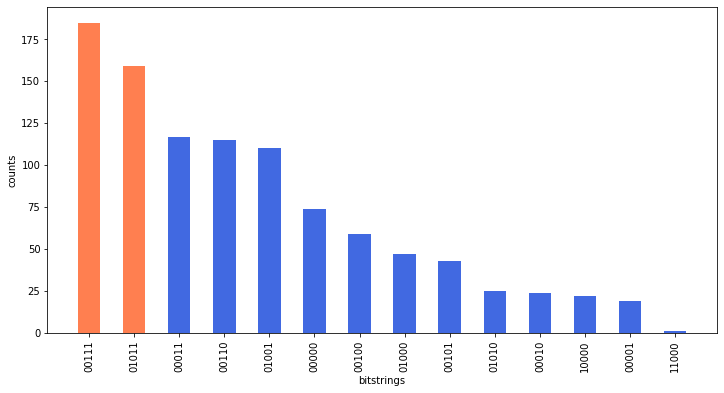

In [15]:
count_dict = quantum_loop(res.x)
plot_distribution(count_dict)

QAOA is capable of finding good variational parameters $\tau$ and $t$. Now, sampling from this final state $\psi_{f}$ will return both MISs of the graph with high probability. Note that listing all maximal independent sets of a graph is also NP, and can be used as a subroutine for solving many NP-complete graph problems. 